In [5]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from scipy import sparse
from sklearn import metrics

import psycopg2
from tqdm import tqdm
from sklearn import utils
from testfixtures import log_capture

%matplotlib inline

Inspiration for this notebook is found at: https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/Document%20classification%20with%20word%20embeddings%20tutorial.ipynb

# Get data from database

In [6]:
#Establish connection to the database and create cursor
conn = psycopg2.connect(
    host="localhost",
    database="Fakenews detector",
    user="postgres",
    password="password")

all_data = pd.read_sql('''with temp_table as (select A.id, A.content, A.length_txt, T.bin_type  
    from articles A left join type_relation T on  A.type = T.type_og 
    where type is not null and T.bin_type is not null)

    select L.url, temp_table.id, temp_table.length_txt, temp_table.content, temp_table.bin_type 
    from location L inner join temp_table on L.id = temp_table.id ''', conn)


In [7]:
all_data

,url,id,length_txt,content,bin_type
0,http://yournewswire.com/law-enforcement-ask-pu...,185128,52,polic washington state ask public stop tweet s...,real
1,http://yournewswire.com/obama-announcing-go-it...,185349,453,obama immigr plan accord articl yahoo news pre...,real
2,http://yournewswire.com/bp-to-pay-18-7bn-for-d...,185623,288,deepwat horizon oil spill kill < number > work...,real
3,http://yournewswire.com/hillary-russian-hacker...,186123,166,hillari clinton care concoct plan accus russia...,real
4,http://yournewswire.com/trump-surrogate-cites-...,186720,309,promin donald trump surrog suggest intern japa...,real
...,...,...,...,...,...
719758,https://wikispooks.com/wiki/Special:SearchByPr...,249915,74,search properti list page properti creation da...,fake
719759,https://wikispooks.com/wiki/Special:SearchByPr...,250025,59,search properti list page properti descript va...,fake
719760,https://wikispooks.com/wiki/Special:SearchByPr...,250036,74,search properti list page properti creation da...,fake
719761,https://www.pravda.ru/society/fashion/couture/...,250332,1355,atomnyi arkhangelsk obretaet novuiu zhizn na v...,fake


In [8]:
df = all_data[['content','bin_type','length_txt']].sample(50000)
df.reset_index(drop=True,inplace=True)

In [9]:
df

,content,bin_type,length_txt
0,credit karl magnacca pith post review find pat...,fake,1147
1,obama administr announc plan cheaper slim mili...,real,251
2,one standard meme russia demograph trajectori ...,fake,688
3,ope start transgend support line although < nu...,real,535
4,yes actual said < url > link stori politicocom...,real,76
...,...,...,...
49995,melania trump put michell obama shame epic way...,fake,314
49996,senat major leader harri reid may endang incum...,fake,33
49997,standard opinion ever sinc set foot new contin...,real,21
49998,fair use notic mani stori site contain copyrig...,fake,134


### Dataframes for LIAR dataset 

In [10]:
df_LIAR = pd.read_csv('Project/Training_cleaned_LIAR_Real.csv')

<AxesSubplot:>

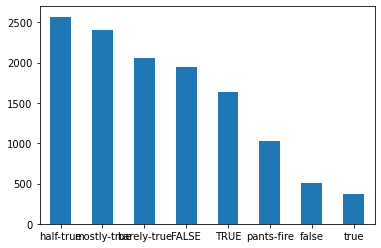

In [11]:
df_LIAR.type.value_counts().plot(kind="bar", rot=0)

In [12]:
def map_type(typee):
    if (typee == 'false') or (typee == 'barely-true') or (typee == 'pants-fire'):
        return 'fake'
    else: 
        return 'real'
df_LIAR['type'] = df_LIAR['type'].apply(lambda x: map_type(x))

<AxesSubplot:>

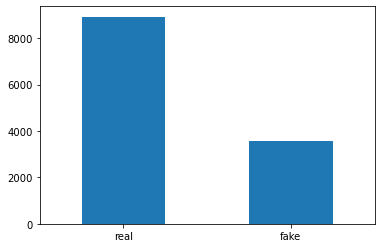

In [13]:
df_LIAR.type.value_counts().plot(kind="bar", rot=0)

In [14]:
df_LIAR.type.value_counts()

real    8925
fake    3588
Name: type, dtype: int64

In [15]:
8925/(8925+3588)

0.7132582114600815

# Exploring data

Amount of words in our sample. 

In [16]:
df['content'].apply(lambda x: len(x.split(' '))).sum()

16395124

<AxesSubplot:>

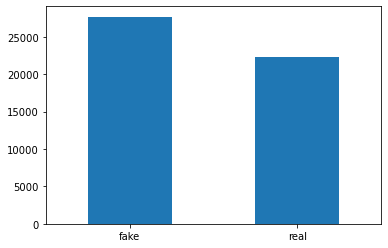

In [17]:
my_tags = ['fake' , 'real']
df.bin_type.value_counts().plot(kind="bar", rot=0)

The data is pretty balanced. We though have fake as majority class.

A naive classifier that predicts everything to be fake already achieves  > 50% accuracy.

In [18]:
df.bin_type.value_counts()

fake    27676
real    22324
Name: bin_type, dtype: int64

In [19]:
27727/(27727+22273)

0.55454

In [20]:
def print_content(index):
    example = df[df.index == index].values[0]
    if len(example) > 0:
        print(example[0])
        print('Genre:', example[1])

In [21]:
print_content(5)

email screen name password confirm password pleas type code click regist confirm agre privaci polici give consent process person data accord privaci polici
Genre: fake


In [22]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [23]:
train_length_txt = train_data['length_txt']
test_length_txt = test_data['length_txt']

train_data = train_data[['content', 'bin_type']]
test_data = test_data[['content', 'bin_type']] 

<AxesSubplot:>

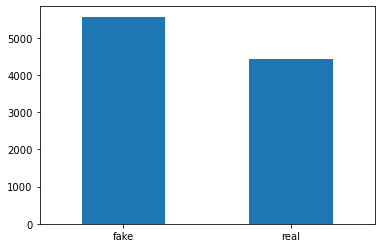

In [24]:
test_data.bin_type.value_counts().plot(kind="bar", rot=0)

# Model evaluation approach

We will use confusion matrices to evaluate all classifiers

In [25]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [27]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['content'])
    predictions = classifier.predict(data_features)
    target = data['bin_type']
    evaluate_prediction(predictions, target)

In [28]:
def predict_PCA(vectorizer, classifier, data, pca):
    data_features = vectorizer.transform(data['content'])
    data_PCA = pca.fit_transform(data_features.toarray())
    predictions = classifier.predict(data_PCA)
    target = data['bin_type']
    evaluate_prediction(predictions, target)

In [29]:
def predict_dense(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['content'])
    predictions = classifier.predict(data_features.toarray())
    target = data['bin_type']
    evaluate_prediction(predictions, target)

In [30]:
def predict_LIAR(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['content'])
    predictions = classifier.predict(data_features)
    target = data['type']
    evaluate_prediction(predictions, target)

In [31]:
def predict_LIAR_dense(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['content'])
    predictions = classifier.predict(data_features.toarray())
    target = data['type']
    evaluate_prediction(predictions, target)

In [32]:
def predict_Length(vectorizer, classifier, data, length_data):
    length_data = length_data.to_numpy().astype(np.float32).reshape((len(length_data),1))
    data_features = vectorizer.transform(data['content'])
    data_features = np.append(data_features.toarray(), length_data, axis=1)
    data_features = sparse.csr_matrix(data_features)
    predictions = classifier.predict(data_features)
    target = data['bin_type']
    evaluate_prediction(predictions, target)

In [33]:
def predict_Length_dense(vectorizer, classifier, data, length_data):
    length_data = length_data.to_numpy().astype(np.float32).reshape((len(length_data),1))
    data_features = vectorizer.transform(data['content'])
    data_features = np.append(data_features.toarray(), length_data, axis=1)
    data_features = sparse.csr_matrix(data_features)
    predictions = classifier.predict(data_features.toarray())
    target = data['bin_type']
    evaluate_prediction(predictions, target)

# TF-IDF

We remove stop-words and use NLTK tokenizer then limit our vocabulary to 3k most frequent words.

In [34]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [35]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names_out()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]    

Term Frequency - Inverse Document Frequency is a little more advanced way to count words in a document. It adjusts for document length, word frequency and most importantly for frequency of a particular word in a particular document.

## Time to make tf-idf  

We choose a vocab of 20,000 most frequent words to save space. 

In [36]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=20000)
train_data_features = tf_vect.fit_transform(train_data['content'])

Wall time: 45 s


Try to make TF_idf with all words.

In [37]:
%%time
tf_vect_50 = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=50000)
train_data_features_50 = tf_vect.fit_transform(train_data['content'])

Wall time: 46.2 s


## Log reg model without PCA 

In [38]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, max_iter=6000)
logreg = logreg.fit(train_data_features, train_data['bin_type'])

In [39]:
tf_vect.get_feature_names_out()[1000:1020]

array(['approv', 'approx', 'approxim', 'apr', 'april', 'apropo', 'apt',
       'aptitud', 'aq', 'aqap', 'aqi', 'aquabounti', 'aquarium',
       'aquarius', 'aquat', 'aqui', 'aquif', 'aquina', 'aquino', 'ar'],
      dtype=object)

accuracy 0.8202
confusion matrix
 [[4655  911]
 [ 887 3547]]
(row=expected, col=predicted)


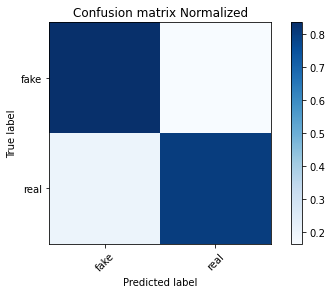

In [40]:
predict(tf_vect, logreg, test_data)

In [41]:
most_influential_words(tf_vect, 0)

['diari',
 'lifesitenewscom',
 'rec',
 'kos',
 'greger',
 'stumbleupon',
 'shutterstock',
 'lifesitenew',
 'crosspost',
 'roar']

### With metadata 

In [42]:
train_data_features

<40000x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 6460446 stored elements in Compressed Sparse Row format>

In [43]:
#make Series as np array
new_train = train_length_txt.to_numpy().astype(np.float32)
#reshape 
new_train = new_train.reshape((len(new_train),1))
#append to train_data_features
new_train = np.append(train_data_features.toarray(), new_train, axis=1)
#Make sparse again
new_train = sparse.csr_matrix(new_train)

In [44]:
#Fit on new X
logreg = logreg.fit(new_train, train_data['bin_type'])

C:\Users\Markus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.8323
confusion matrix
 [[4709  857]
 [ 820 3614]]
(row=expected, col=predicted)


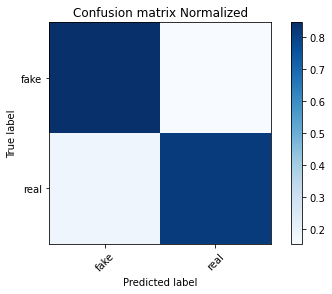

In [45]:
predict_Length(tf_vect, logreg, test_data, test_length_txt)

### LIAR 

In [46]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, max_iter=6000)
logreg = logreg.fit(train_data_features, train_data['bin_type'])

In [47]:
LIAR_test = df_LIAR[['content', 'type']]

In [48]:
LIAR_test.head(10)

,content,type
0,hillari clinton agre john mccain vote give geo...,real
1,health care reform legisl like mandat free sex...,real
2,econom turnaround start end term,real
3,chicago bear start quarterback last < number >...,real
4,jim dunnam live district repres year,fake
5,im person stage work activ last year pass alon...,real
6,howev took $ < number > million oregon lotteri...,real
7,say gop primari oppon glenn grothman joe leibh...,real
8,first time histori share nation popular vote m...,real
9,sinc < number > near < number > million americ...,real


accuracy 0.5745224966035323
confusion matrix
 [[1261 2327]
 [2997 5928]]
(row=expected, col=predicted)


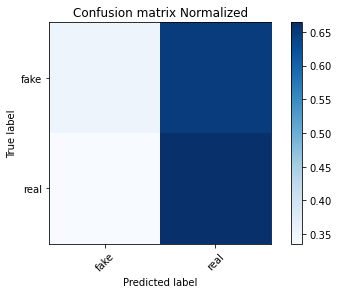

In [49]:
predict_LIAR(tf_vect, logreg, LIAR_test)

## Random Forrest without PCA

In [50]:
train_data_features

<40000x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 6460446 stored elements in Compressed Sparse Row format>

In [51]:
# WE define for measurements Posetive to be real news, and negative to be false news.

Rand_forrest = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 20, max_features = 'sqrt', n_jobs=8)
Rand_forrest = Rand_forrest.fit(train_data_features, train_data['bin_type'])


accuracy 0.8111
confusion matrix
 [[4636  930]
 [ 959 3475]]
(row=expected, col=predicted)


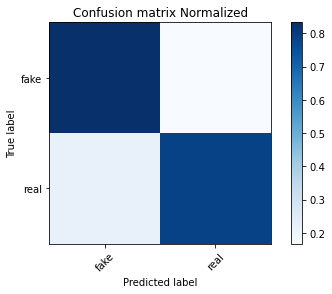

In [52]:
predict(tf_vect, Rand_forrest, test_data)

### Random forest with 50k features 

accuracy 0.8071
confusion matrix
 [[4622  944]
 [ 985 3449]]
(row=expected, col=predicted)


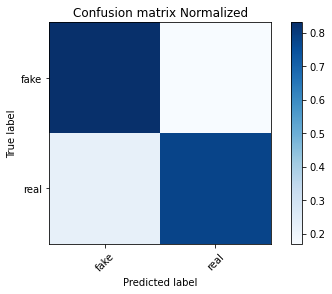

In [53]:
Rand_forrest_50 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 20, max_features = 'sqrt', n_jobs=8)
Rand_forrest_50 = Rand_forrest_50.fit(train_data_features_50, train_data['bin_type'])

predict(tf_vect, Rand_forrest_50, test_data)

### LIAR dataset 

accuracy 0.34124510509070566
confusion matrix
 [[3103  485]
 [7758 1167]]
(row=expected, col=predicted)


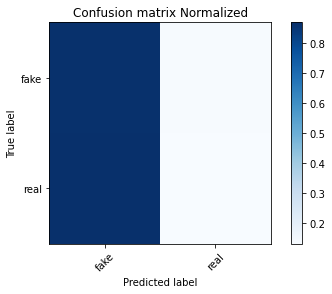

In [54]:
predict_LIAR(tf_vect, Rand_forrest_50, LIAR_test)

## Bayes Naive

accuracy 0.7299
confusion matrix
 [[3285 2281]
 [ 420 4014]]
(row=expected, col=predicted)


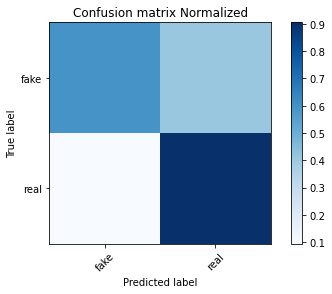

In [55]:
# SCIkit link: https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb = gnb.fit(train_data_features.toarray(), train_data['bin_type'])

predict_dense(tf_vect, gnb, test_data)

### LIAR dataset 

accuracy 0.6856868856389355
confusion matrix
 [[ 243 3345]
 [ 588 8337]]
(row=expected, col=predicted)


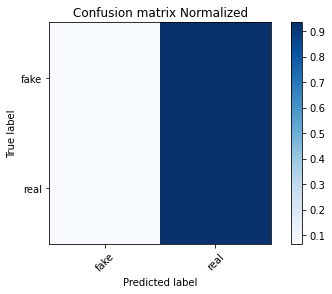

In [56]:
predict_LIAR_dense(tf_vect, gnb, LIAR_test)

### With Metadata 

accuracy 0.7852
confusion matrix
 [[4667  899]
 [1249 3185]]
(row=expected, col=predicted)


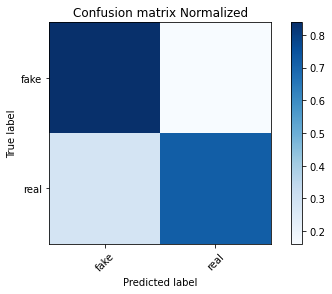

In [57]:
gnb = gnb.fit(new_train.toarray(), train_data['bin_type'])

predict_Length_dense(tf_vect, gnb, test_data, test_length_txt)

## Neural network 

In [58]:
clf = MLPClassifier(solver='lbfgs', max_iter = 6000, alpha=1e-5, hidden_layer_sizes=(6, 2), random_state=1)
clf = clf.fit(train_data_features, train_data['bin_type'])

accuracy 0.8329
confusion matrix
 [[4720  846]
 [ 825 3609]]
(row=expected, col=predicted)


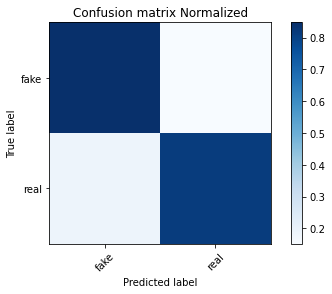

In [59]:
predict(tf_vect, clf, test_data)

### Test on LIAR dataset  

accuracy 0.5806760968592664
confusion matrix
 [[1204 2384]
 [2863 6062]]
(row=expected, col=predicted)


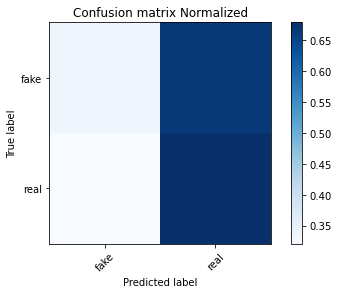

In [60]:
predict_LIAR(tf_vect, clf, LIAR_test)

## Statistics of accuracy

In [61]:
# Importing the required libs
from tqdm import tqdm
from scipy.stats import norm, chi2
from scipy.stats import t as t_dist
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold

# Libs implementations
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import paired_ttest_5x2cv
from mlxtend.evaluate import proportion_difference
from mlxtend.evaluate import paired_ttest_kfold_cv
from mlxtend.evaluate import paired_ttest_resampled



In [62]:
#To begin with I compare random f. and neural net. against log reg which has the best accuracy.
#I begin with randoom forest against log reg.

predicted_Randfor = Rand_forrest.predict(tf_vect.transform(test_data['content']))
predicted_logreg = logreg.predict(tf_vect.transform(test_data['content']))
predicted_neural = clf.predict(tf_vect.transform(test_data['content']))
real_labels = test_data['bin_type'].to_numpy()

In [63]:
print("McNemar's test: random forrest vs. log reg")
table = mcnemar_table(y_target=real_labels, y_model1=predicted_Randfor, y_model2=predicted_logreg)
chi2_, p = mcnemar(ary=table, corrected=True)
print(f"chi² statistic: {chi2_}, p-value: {p}\n")

McNemar's test: random forrest vs. log reg
chi² statistic: 3.7656903765690375, p-value: 0.05231425786695537



In [64]:
print("McNemar's test: neural network vs. log reg")
table = mcnemar_table(y_target=real_labels, y_model1=predicted_neural, y_model2=predicted_logreg)
chi2_, p = mcnemar(ary=table, corrected=True)
print(f"chi² statistic: {chi2_}, p-value: {p}\n")

McNemar's test: neural network vs. log reg
chi² statistic: 22.90909090909091, p-value: 1.6984666430537982e-06



In [65]:
print("McNemar's test: random forrest vs. neural network")
table = mcnemar_table(y_target=real_labels, y_model1=predicted_Randfor, y_model2=predicted_neural)
chi2_, p = mcnemar(ary=table, corrected=True)
print(f"chi² statistic: {chi2_}, p-value: {p}\n")

McNemar's test: random forrest vs. neural network
chi² statistic: 22.748309178743963, p-value: 1.8466654822258137e-06



In [66]:
test_data

,content,bin_type
33553,santorum dont write book dont brown exampl you...,real
9427,Â©ï¸dr ilya sandra perlingieri august < numbe...,fake
199,soviet spys dire warn < number > year ago come...,fake
12447,look someth page look found longer avail tri s...,fake
39489,fair use notic mani stori site contain copyrig...,fake
...,...,...
28567,stuck motel room wait car repair flick channel...,real
25079,< number > share facebook twitter reddit stumb...,real
18707,wilkerson courtappoint attorney keep fight cli...,fake
15200,oakland better way express feel verdict thousa...,fake


## ROC Curve

In [67]:
#define metrics
y_pred_proba_RF = Rand_forrest.predict_proba(tf_vect.transform(test_data['content']))[::,1]
y_pred_proba_NN = clf.predict_proba(tf_vect.transform(test_data['content']))[::,1]

fpr_RF, tpr_RF, _ = metrics.roc_curve(test_data['bin_type'].to_numpy(),  y_pred_proba_RF, pos_label='real')
fpr_NN, tpr_NN, _ = metrics.roc_curve(test_data['bin_type'].to_numpy(),  y_pred_proba_NN, pos_label='real')

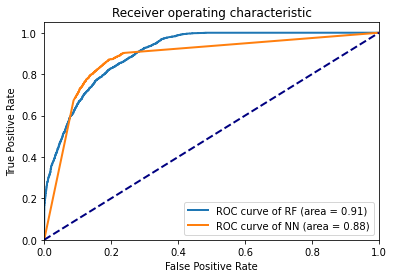

In [68]:
plt.figure()
lw = 2
plt.plot(fpr_RF,tpr_RF, lw=2, label="ROC curve of RF (area = %0.2f)" % metrics.auc(fpr_RF, tpr_RF))
plt.plot(fpr_NN,tpr_NN, lw=2, label="ROC curve of NN (area = %0.2f)" % metrics.auc(fpr_NN, tpr_NN))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Averaging Word Vectors

Now let's use more complex features rather than just counting words.

A great recent achievement of NLP is the word2vec embedding. See Chris Moody's video for a great introduction to word2vec.

First we load a word2vec model. It has been pre-trained by Google on a 100 billon word Google News corpus. You can play with this model using a fun web-app.

Link to the web-app: http://rare-technologies.com/word2vec-tutorial/#app

Vocabulary size: 3 mln words.

In [69]:
%%time 
wv = gensim.models.KeyedVectors.load_word2vec_format( "C:/Users/Markus/OneDrive/Dokumenter/4. Semester/DataScience/Project/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

2022-06-10 11:58:08,416 : INFO : loading projection weights from C:/Users/Markus/OneDrive/Dokumenter/4. Semester/DataScience/Project/GoogleNews-vectors-negative300.bin.gz
2022-06-10 11:58:52,245 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:/Users/Markus/OneDrive/Dokumenter/4. Semester/DataScience/Project/GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-06-10T11:58:52.245832', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'load_word2vec_format'}
<timed exec>:2: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
2022-06-10 11:58:53,959 : WARNING : destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


Wall time: 46.2 s


In [70]:
from itertools import islice
list(islice(wv.index_to_key, 13000, 13020))

['indoors',
 'commercially',
 'scouts',
 'State_Condoleezza_Rice',
 'Election_Day',
 'satellites',
 'Dalton',
 'Pack',
 'Marina',
 'Cherry',
 'selective',
 'dear',
 'scout',
 'blogger',
 'Tony_Blair',
 'Nairobi',
 'Zurich',
 'Milford',
 'Notes_@',
 'motel']

Now we have a vector for each word. How do we get a vector for a sequence of words (aka a document)?

The most naive way is just to take an average. Mike Tamir has suggested that the resulting vector points to a single word summarising the whole document. For example all words in a book ‘A tale of two cities’ should add up to 'class-struggle’

In [71]:
def word_avg(wv, word_lst):
    mean =  []
    for word in word_lst: 
        if wv.__contains__(word):
            mean.append(wv[word])
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_avg2(wv, word_lst):
    accum_vec =  np.zeros(wv.vector_size)
    count_words = 0
    for word in word_lst: 
        if wv.__contains__(word):
            accum_vec += wv[word]
            count_words += 1
    if count_words > 0:
        accum_vec /= count_words
        accum_vec /= np.linalg.norm(accum_vec) 
    return accum_vec

def  word_averaging_list(wv, text_list):
    return np.vstack([word_avg(wv, review) for review in text_list ])

def  word_averaging_list2(wv, text_list):
    return np.vstack([word_avg2(wv, review) for review in text_list ])

A tokenizer function whcih preserves the uppercases. Doesn't change anything for us 

In [72]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [73]:
LIAR_test

,content,type
0,hillari clinton agre john mccain vote give geo...,real
1,health care reform legisl like mandat free sex...,real
2,econom turnaround start end term,real
3,chicago bear start quarterback last < number >...,real
4,jim dunnam live district repres year,fake
...,...,...
12508,first time decad import account less half oil ...,real
12509,say donald trump bankrupt compani twice four time,real
12510,john mccain georg bush absolut plan univ healt...,real
12511,new poll show < number > percent support presi...,fake


In [74]:
%%time
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['content']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['content']), axis=1).values

#For liar dataset
test_tokenized_LIAR = LIAR_test.apply(lambda r: w2v_tokenize_text(r['content']), axis=1).values

Wall time: 1min 6s


In [75]:
%%time
X_train_word_average = word_averaging_list2(wv,train_tokenized)
X_test_word_average = word_averaging_list2(wv,test_tokenized)

Wall time: 46.6 s


In [76]:
#For liar dataset
X_test_LIAR_word = word_averaging_list2(wv,test_tokenized_LIAR)

In [77]:
X_test_LIAR_word

array([[-0.02512712,  0.02920723, -0.01342775, ..., -0.06722651,
        -0.02093714,  0.04701394],
       [-0.03034249,  0.08719108,  0.0135276 , ..., -0.00632232,
        -0.00974568,  0.07835492],
       [-0.07868972,  0.06924561, -0.04191448, ...,  0.02142466,
        -0.00582014, -0.02424655],
       ...,
       [-0.026734  ,  0.04491908,  0.03881444, ..., -0.0565627 ,
        -0.03846441,  0.07978426],
       [ 0.00901354,  0.01743798,  0.04165528, ..., -0.02753077,
         0.00772472, -0.00835433],
       [-0.02301988, -0.01291174, -0.02225298, ..., -0.09297893,
        -0.07763655,  0.02741469]])

In [78]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.bin_type)

Wall time: 96.2 ms


KNeighborsClassifier(algorithm='brute', metric='cosine', n_jobs=1,
                     n_neighbors=3)

In [79]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

Wall time: 9.93 s


accuracy 0.7568
confusion matrix
 [[4287 1279]
 [1153 3281]]
(row=expected, col=predicted)


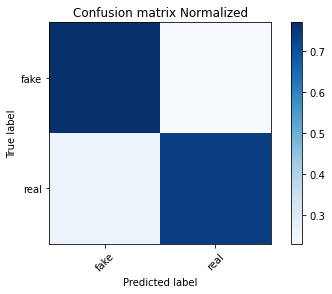

In [80]:
evaluate_prediction(predicted, test_data.bin_type)

KNN is almost as bad as 'everything fake' baseline! Let's see if logistic regression is better.

## Log Reg 

In [81]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, max_iter=6000)
logreg = logreg.fit(X_train_word_average, train_data['bin_type'])

predicted = logreg.predict(X_test_word_average)

Wall time: 4.69 s


accuracy 0.7731
confusion matrix
 [[4423 1143]
 [1126 3308]]
(row=expected, col=predicted)


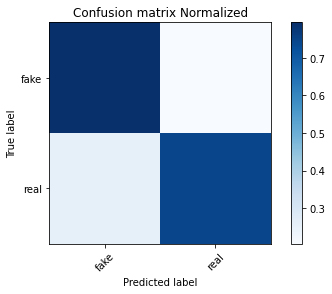

In [82]:
evaluate_prediction(predicted, test_data.bin_type)

### LIAR dataset

accuracy 0.5720450731239511
confusion matrix
 [[1110 2478]
 [2877 6048]]
(row=expected, col=predicted)


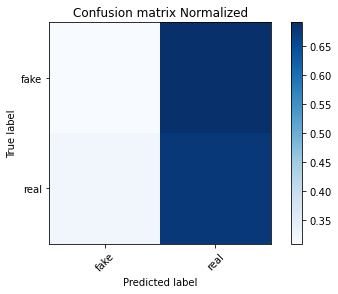

In [83]:
predicted = logreg.predict(X_test_LIAR_word)
evaluate_prediction(predicted, LIAR_test.type)

## Make Random Forrest classification without PCA

In [84]:
# WE define for measurements Posetive to be real news, and negative to be false news.

Rand_forest = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 20, max_features = 'sqrt', n_jobs=8)
Rand_forest = Rand_forest.fit(X_train_word_average, train_data['bin_type'])

predicted = Rand_forest.predict(X_test_word_average)

accuracy 0.7865
confusion matrix
 [[4500 1066]
 [1069 3365]]
(row=expected, col=predicted)


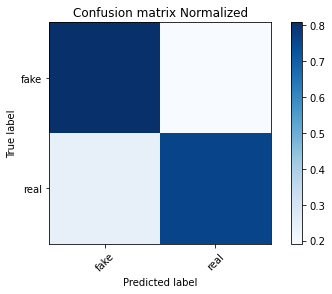

In [85]:
evaluate_prediction(predicted, test_data.bin_type)

### With LIAR

accuracy 0.5156237512986495
confusion matrix
 [[1252 2336]
 [3725 5200]]
(row=expected, col=predicted)


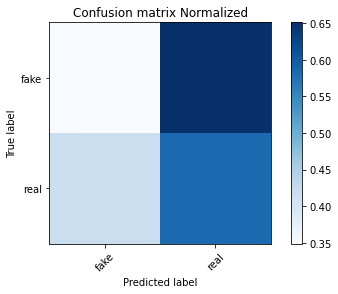

In [86]:
predicted = Rand_forest.predict(X_test_LIAR_word)
evaluate_prediction(predicted, LIAR_test.type)

## Bayes Naive

In [87]:
## Bayes naive  
# SCIkit link: https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb = gnb.fit(X_train_word_average, train_data['bin_type'])

predicted = gnb.predict(X_test_word_average)

accuracy 0.6383
confusion matrix
 [[2967 2599]
 [1018 3416]]
(row=expected, col=predicted)


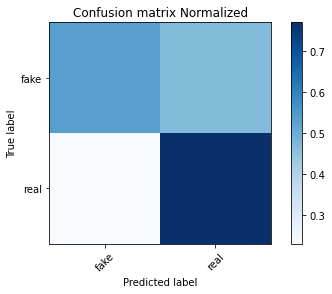

In [88]:
evaluate_prediction(predicted, test_data.bin_type)

### With LIAR 

accuracy 0.28818029249580435
confusion matrix
 [[3548   40]
 [8867   58]]
(row=expected, col=predicted)


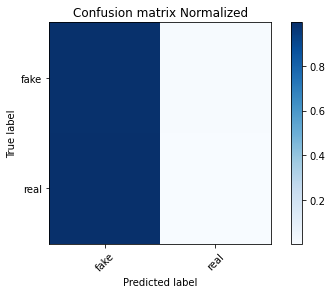

In [89]:
predicted = gnb.predict(X_test_LIAR_word)
evaluate_prediction(predicted, LIAR_test.type)

## Neural network 

In [90]:
clf_word_avg = MLPClassifier(solver='lbfgs', max_iter = 6000, alpha=1e-5, hidden_layer_sizes=(8,2), random_state=1)
clf_word_avg = clf_word_avg.fit(X_train_word_average, train_data['bin_type'])

predicted = clf_word_avg.predict(X_test_word_average)

accuracy 0.7976
confusion matrix
 [[4500 1066]
 [ 958 3476]]
(row=expected, col=predicted)


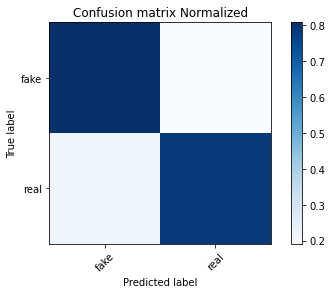

In [91]:
evaluate_prediction(predicted, test_data.bin_type)

### With LIAR  

accuracy 0.604890913450012
confusion matrix
 [[ 954 2634]
 [2310 6615]]
(row=expected, col=predicted)


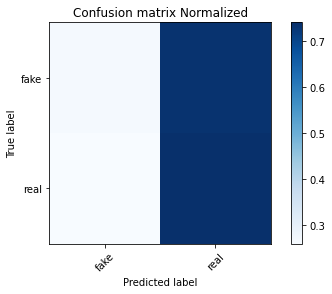

In [92]:
predicted = clf_word_avg.predict(X_test_LIAR_word)
evaluate_prediction(predicted, LIAR_test.type)